This notebook has to be ran after [Notebook 2](https://github.com/FabCec/planned_replacements/blob/master/2.%20Data%20wrangling.ipynb). At the end of that notebook, we have saved a folder with the dataset associated to the model specified in ModelName on our laptop. In that dataset, we removed all the columns with non-informative SMART metrics. We will report the result for the model 'Hitachi HDS722020ALA330'. 

In the original dataset, we have 4683 unique HDDs for the model 'Hitachi HDS722020ALA330'. In the years 2015-17, there has been reported 152 failures, i.e., the 3.24% of the HDDs has failed. The data for the HDDs stop being collected either due to their failure or for a preventive replacement policy whose details are not mentioned in the dataset. Such policy can be reverse-engineered from the dataset and will be discussed later. 

For each HDD the dataframe consists of a set of time-series, one per selected SMART metric, indexed by day. There are only 7 SMART metrics (out of the original 45) that we believe could potentially provide meaningful information in identifying HDDs close to a failure.

We now read the saved files and further wrangle the dataframes.

In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Read the dataset associated to a specific model:  (ex:'Hitachi HDS722020ALA330', 'ST8000DM002')

ModelName = 'Hitachi HDS722020ALA330' 

folder_name_model = ModelName.replace(' ', '_')
folder_name = 'Data/' + folder_name_model

df15 = pd.read_csv(folder_name + '/Model_15.csv')
df16 = pd.read_csv(folder_name + '/Model_16.csv')
df17 = pd.read_csv(folder_name + '/Model_17.csv')

# Cast the data entries as datetime entries

df15['date'] = pd.to_datetime(df15['date'])
df16['date'] = pd.to_datetime(df16['date'])
df17['date'] = pd.to_datetime(df17['date'])

# Concatenate the yearly datasets in an unique pandas DataFrame : df

df = pd.concat([df15,df16,df17], ignore_index=True)

del df15
del df16
del df17

del df['Unnamed: 0']  

df.describe()

,failure,smart_1_normalized,smart_5_normalized,smart_7_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_196_normalized
count,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06,2.608197e+06
mean,5.827781e-05,9.970960e+01,9.995405e+01,9.999997e+01,1.019221e+02,9.969824e+01,9.969824e+01,9.995118e+01
std,7.633769e-03,1.643947e+00,1.190153e+00,1.148439e-02,6.035827e+00,6.207148e-01,6.207148e-01,1.220344e+00
min,0.000000e+00,1.000000e+00,5.000000e+00,8.400000e+01,4.600000e+01,6.800000e+01,6.800000e+01,4.000000e+00
25%,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,9.900000e+01,9.900000e+01,1.000000e+02
50%,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
75%,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
max,1.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.230000e+02,1.000000e+02,1.000000e+02,1.000000e+02


The dataframe 'df' is further wrangled so as to obtain the following three separate dataframes.

1. **df_serialnumber**. This dataframe is indexed by the unique ID of the HDD and has the following columns:
  - 'date_first': First appearance of the HDD
  - 'date\_last': Last appearance of the HDD
  - 'state': Type of HDD. This categorical feature can be 'failing' if the HDD fails at a certain point, 'healthy' if it does not, or 'wrong' if the date of failure
  does not coincide with its last appearance. \\
  A unique HDD (JK1101B9JPJ4NF) is categorized as wrong for the model 'Hitachi HDS722020ALA330' and we removed it from the dataset. 
  
2. **df_smartmetrics**. For each of the SMART metric which is filtered we keep track of its mean value, std, min, and maximum.

3. **df**. This is a multi-indexed dataframe in which the first level is given by the HDD serial number and the second by the date
 and the columns are given by the different SMART metrics. Note that when we slice 
 for a specific serial number we obtain a time series for each SMART metrics whose last entry is related to the day of failure of an HDD with a failing state.



In [3]:
## Create df_serialnumber :

# Extract the data associated to each hard disk: whether it will fail, the first, and the last entry   

df_failed = df.groupby('serial_number').failure.sum()   # 0/1 depending on whether a HDD will experienced failure or not 
df_last_app = df.groupby('serial_number').date.max()
df_first_app = df.groupby('serial_number').date.min()

# Extract day of failure for every failing HDD
df_failure_days = df.loc[df['failure']==1,['date','serial_number']]
df_failure_days.index = df_failure_days['serial_number']

del df_failure_days['serial_number']

# Generate df_serialnumber    
df_serialnumber = pd.concat([df_failed, df_first_app, df_last_app, df_failure_days], axis = 1)
df_serialnumber.columns = ['failure', 'date_first', 'date_last', 'date_failure']

del df_failed
del df_last_app
del df_first_app
del df_failure_days

# Check whether the last entry of a failing hard-disk coincides with its failure day
df_serialnumber['failure_correct'] = df_serialnumber.failure * (df_serialnumber.date_last == df_serialnumber.date_failure)

# We now determine whether each serial_number is going to fail, will remain healthy, or is a wrong entry
dictionary_serial_number_state ={ (1,1): 'fail',
                                  (0,0): 'healthy',
                                  (1,0): 'wrong' }

df_serialnumber['state'] = [ dictionary_serial_number_state[(df_serialnumber.loc[s_n,'failure'],df_serialnumber.loc[s_n,'failure_correct'])] for s_n in df_serialnumber.index]

del df_serialnumber['failure']
del df_serialnumber['failure_correct']

# In the example with ModelName = 'Hitachi HDS722020ALA330', we have one wrongly reported hard-disk: 'JK1101B9JPJ4NF' 
df_serialnumber[df_serialnumber['state'] == 'wrong']

,date_first,date_last,date_failure,state
JK1101B9JPJ4NF,2015-01-01,2016-08-04,2015-03-30,wrong


In [4]:
## Create df :

# Add a column to the original dataframe df which capture the state of the HDD 
# and exclude the data relative to the 'wrong' entries

df['state'] = df.serial_number.apply(lambda x : df_serialnumber.state[x])
df = df[df['state'] != 'wrong']

df['D_from_first'] = [ (df.iloc[i,0] - df_serialnumber.date_first[df.iloc[i,1]]).days for i in range(df.shape[0])]
df['D_to_last'] = [ (df.iloc[i,0] - df_serialnumber.date_last[df.iloc[i,1]]).days for i in range(df.shape[0])]

# The dataset has a natural structure with a 2-levels indexing :
# 1) The outer level captures a specific hard-disk (identified by the serial_number) ;
# 2) The inner level captures the TimeStamp of the recording. 

df = df.set_index(['serial_number','date']).sort_index()

df.head()

failure  smart_1_normalized  smart_5_normalized  \
serial_number  date                                                          
JK1100B8G3B7AT 2015-01-01        0               100.0               100.0   
               2015-01-02        0               100.0               100.0   
               2015-01-03        0               100.0               100.0   
               2015-01-04        0               100.0               100.0   
               2015-01-05        0               100.0               100.0   

                           smart_7_normalized  smart_8_normalized  \
serial_number  date                                                 
JK1100B8G3B7AT 2015-01-01               100.0               100.0   
               2015-01-02               100.0               100.0   
               2015-01-03               100.0               100.0   
               2015-01-04               100.0               100.0   
               2015-01-05               100.0               100.0   

                           smart_192_normalized  smart_193_normalized  \
serial_number  date                                                     
JK1100B8G3B7AT 2015-01-01                 100.0                 100.0   
               2015-01-02                 100.0                 100.0   
               2015-01-03                 100.0                 100.0   
               2015-01-04                 100.0                 100.0   
               2015-01-05                 100.0                 100.0   

                           smart_196_normalized    state  D_from_first  \
serial_number  date                                                      
JK1100B8G3B7AT 2015-01-01                 100.0  healthy             0   
               2015-01-02                 100.0  healthy             1   
               2015-01-03                 100.0  healthy             2   
               2015-01-04                 100.0  healthy             3   
               2015-01-05                 100.0  healthy             4   

                           D_to_last  
serial_number  date                   
JK1100B8G3B7AT 2015-01-01       -602  
               2015-01-02       -601  
               2015-01-03       -600  
               2015-01-04       -599  
               2015-01-05       -598

In [5]:
## Create df_smartmetrics :

# smart_metrics has the list of names for the SMART metrics we are considering for the model ModelName
smart_metrics = df.columns[1:-3]

def col_info(x):
    '''This function returns a Pandas Series with info associated to each row'''
    return pd.Series(index=['min','max','mean','std'],data=[x.min(),x.max(),x.mean(),x.std()])

# df_smartmetrics_minmax is a dataframe with the minimum and the maximum for each of these metrics.
df_smartmetrics = df[smart_metrics].apply(col_info)

df_smartmetrics.head()

,smart_1_normalized,smart_5_normalized,smart_7_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_196_normalized
min,1.000000,5.000000,84.000000,46.000000,68.000000,68.000000,4.000000
max,100.000000,100.000000,100.000000,123.000000,100.000000,100.000000,100.000000
mean,99.711073,99.954042,99.999974,101.917847,99.698264,99.698264,99.951169
std,1.639546,1.190285,0.011486,6.029818,0.620740,0.620740,1.220479


In [6]:
## We now further extract the data associated to healthy HDDs and failing HDDs at different time prior to the failure

df_failing = df[df['state'] == 'fail']  # We filter the hard-disk failing in the considered time frame
df_healthy = df[df['D_to_last'] < -365 ] # We filter the data associated to HDDs that won't fail for an year

# Extract the SMART metrics associated to hard-disks in their last day of life : df_failure

df_failure = df_failing.groupby(level='serial_number').tail(1)

def extract_df_close_to_failure (df_failing, K):
    '''Extract the data associated to failing HDDs K days prior to the failure (K larger or equal than 1)'''
    df_failure_K = df_failing.groupby(level='serial_number').tail(K)
    return df_failure_K.groupby(level='serial_number').head(1)



# Exploratory Data Analysis (EDA)

So far we excluded most of the SMART metrics by saying that are not informative, we now focus on those that we kept and aim to understand whether their analysis could help in predicting failures of HDDs.

First of all, we group the dataframe **df** according to the state of the HDD. In particular, we obtain a dataframe **df_healthy** containing only the observations associated to HDD which do not fail and **df_failing** with the others. The latter dataframe is then used to obtain **df_failure** and a **df_failure_K** (via the function **extract_df_close_to_failure**) containing only the observations of the HDDs on the day of the failure and $K$ days before the failure, respectively.

We aim to answer the following questions:

- Does the distribution of the SMART metrics differ between **df_healthy** and **df_failure**?
- If it does, how fast the SMART metrics deteriorate? That is to say, for which values of $K$ we can distinguish the distribution of **df_healthy** and **df_failure_K**? Note that a larger $K$ would help, it would provide more time to identify a close-to-failure HDD.


## EDA 1 - Distribution of SMART metrics:

We now present the different distributions for **df_healthy**, **df_failure**, and **df_failure_K** for $K = 7, 14$. Note that the y-scale is logarithmic, nevertheless metrics 1, 5, 8, and 196 have an interesting trend. 

On the one hand not only the SMART metric on the day of failure seems to be stochastically smaller than for healthy HDDs, but also the SMART metrics seem to worsen already one week before the failure.

On the other hand, the vast majority of HDDs do not show a worsening in any of the SMART metrics even on the day of their failure. Hence, the failures of these HDDs will not be detected by any kind of analysis based on this dataset, a finer sensing policy (hourly instead of daily perhaps) might help.

In [7]:
# The function CompareHistograms plots multi-bar histograms of a list of np arrays. It sets the right value for the width
# and the position of the bar according to the range and the number of bins.

def compare_histograms (*list_array, hist_range, num_bins = 10) :
    '''Create a histogram with multiple bars from a list of arrays. Each array is plotted across hist_range'''
    
    fig, ax = plt.subplots(1,1)
    
    # Initialize the width of each bar
    width_0 = ((hist_range[1]-hist_range[0])/num_bins) / (len(list_array)+1)
    
    for ind, arr in enumerate(list_array) :
        
        heights_arr , bins_arr = np.histogram(arr, normed=True, range = hist_range, bins = num_bins)
        ax.bar(bins_arr[:-1] +  ((hist_range[1]-hist_range[0])/num_bins)/2 + width_0*(ind + 1), heights_arr, width=width_0) 

    return fig,ax


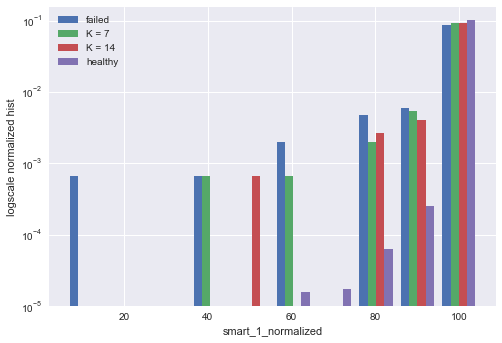

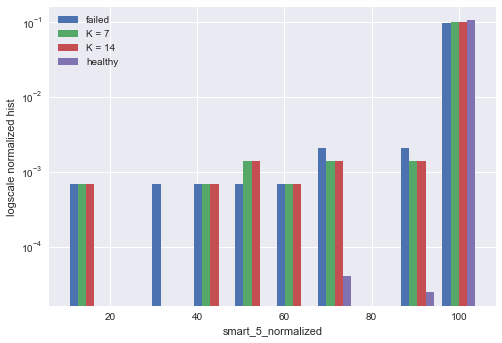

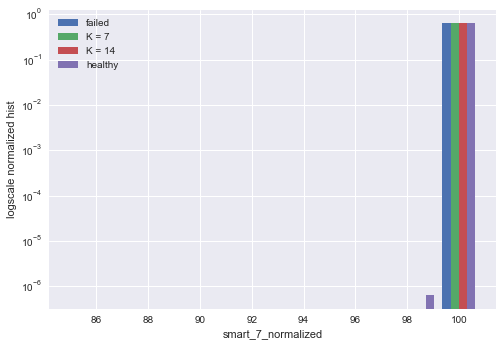

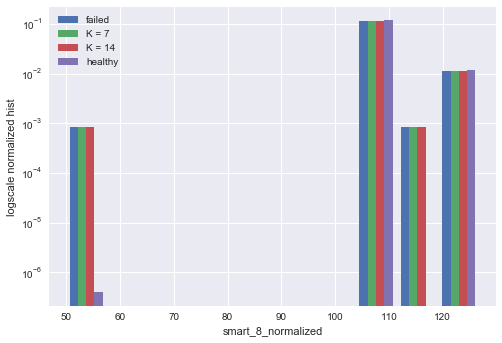

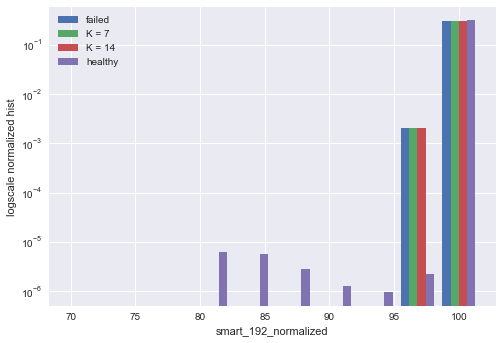

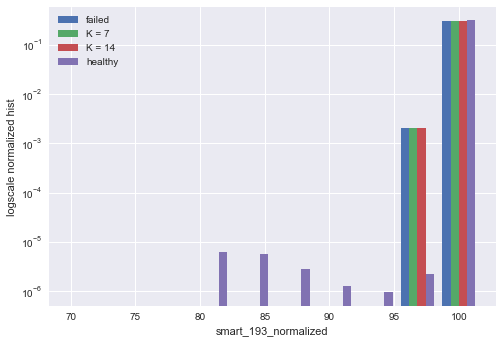

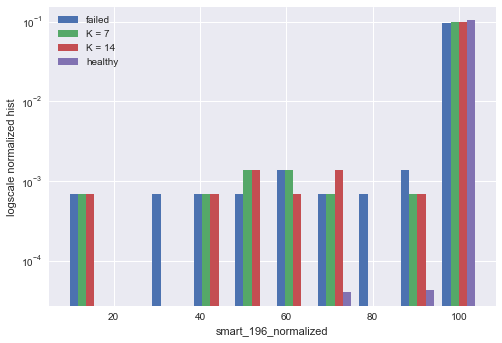

In [8]:
df_failure_7 = extract_df_close_to_failure (df_failing, 7)
df_failure_14 = extract_df_close_to_failure (df_failing, 14)

# We now apply CompareHistograms to every SMART metric and plot the multi-bar histograms

for smart_metric in smart_metrics :

    dfh1 = df_failure.loc[(slice(None),slice(None)), smart_metric].values
    dfh2 = df_failure_7.loc[(slice(None),slice(None)), smart_metric].values
    dfh3 = df_failure_14.loc[(slice(None),slice(None)), smart_metric].values
    dfh4 = df_healthy.loc[(slice(None),slice(None)), smart_metric].values

    fig, ax = compare_histograms(dfh1, dfh2, dfh3, dfh4, hist_range = (df_smartmetrics.loc['min',smart_metric],df_smartmetrics.loc['max',smart_metric]) )
    
    plt.xlabel(smart_metric)
    plt.ylabel('logscale normalized hist')
    
    plt.yscale('log')
    plt.legend(['failed', 'K = 7', 'K = 14', 'healthy'])
    
    plt.show()



## EDA 2 - SMART metrics and days-to-failure:

In order to answer the second question, we now group the entries of the **df_failing** dataframe by the days to failure. Note that the values of the SMART metrics 1,5, and 196 start to decrease about two weeks ahead of the failure. 

However, note that the fraction of failing HDDs that display a decrease in the SMART metrics values are below 10%. The large majority of the failures cannot be captured by the data in the present dataset. These metrics may decrease as the failure gets closer but cannot be captured by the daily measurements that are reported in the dataset in use.

Nevertheless, capturing 10% of the failures would be already a significant results.

It is quite surprising the worsening trend of the most informative SMART metrics, i.e., 1, 5, 196, as the HDDs approach failure. Instead of a progressive worsening, we observe that a first jump down in the performance happens roughly 2 weeks before the failure, then the metrics remain quite constant till a further worsening happens in the day before the failure. 

We now plot the quantiles of the SMART metrics of the HDDs are plotted versus the days to failure.

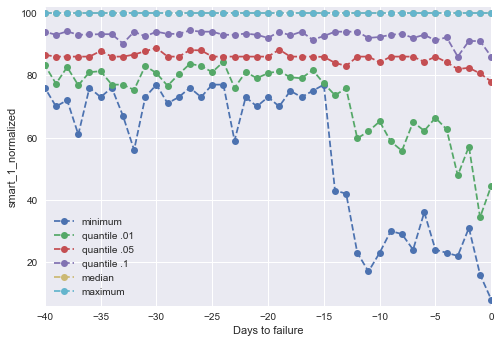

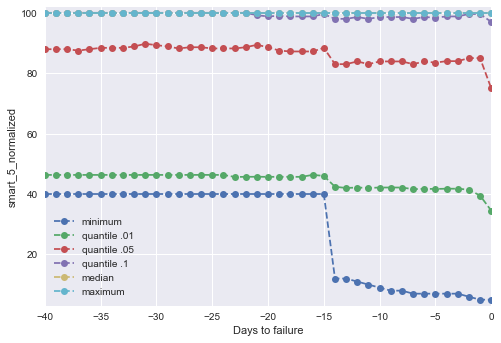

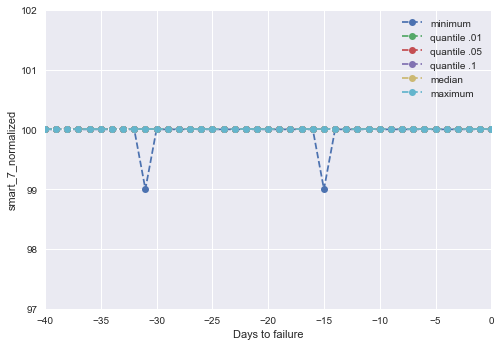

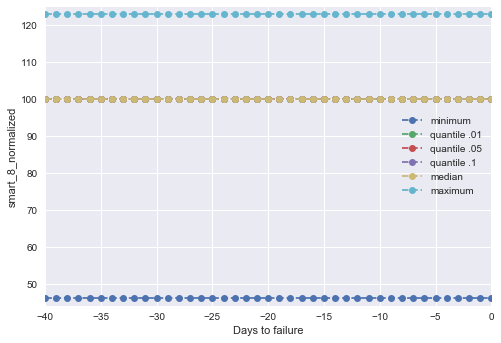

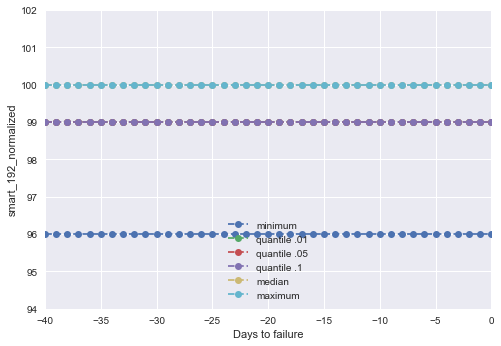

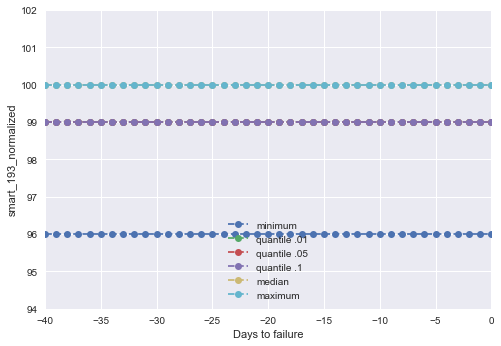

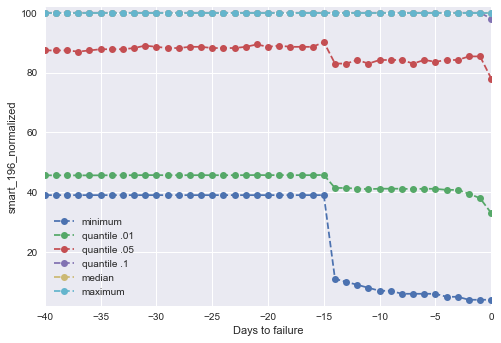

In [9]:
df_failing_reset = df_failing.reset_index()

perc_min = df_failing_reset.groupby('D_to_last')[smart_metrics].min()
perc_01  = df_failing_reset.groupby('D_to_last')[smart_metrics].quantile(.01)
perc_05  = df_failing_reset.groupby('D_to_last')[smart_metrics].quantile(.05)
perc_10  = df_failing_reset.groupby('D_to_last')[smart_metrics].quantile(.1)
perc_50  = df_failing_reset.groupby('D_to_last')[smart_metrics].quantile(.5)
perc_max = df_failing_reset.groupby('D_to_last')[smart_metrics].max()

# We now apply CompareHistograms to every SMART metric and plot the multi-bar histograms

for smart_metric in smart_metrics :

    plt.plot(perc_min[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_01[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_05[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_10[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_50[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_max[smart_metric], marker = 'o', linestyle = '--')

    plt.axis( [-40, 0, min(perc_min[smart_metric]) - 2, max(perc_max[smart_metric]) + 2] )
    plt.xlabel('Days to failure')
    plt.ylabel(smart_metric)
    plt.legend(['minimum',
                'quantile .01',
                'quantile .05',
                'quantile .1',
                'median',
                'maximum'])
    
    plt.show()

## EDA 3 - Correlation of SMART metrics and age/time-to-failure of the HDDs:

We now aim to determine whether the performance of the SMART metrics are correlated with the age of the HDDs. We group the entries of the **df_failing** dataframe by the age of the HDD, and we look at the correlation matrices.

- There is not a clear correlation with the age of the HDD. 

This is encouraging, in fact we aim to use the SMART metrics as an approximation for the time-to-failure, not for the age of an HDD.

In [10]:
## When we look at the age of an HDD, we need to exclude the HDDs that are already in the dataframe on 2015-01-01

df_reset = df.reset_index()

df_present = df_reset[df_reset['date'] == '2015-01-01']               
set_of_present_serialnumbers = set(df_present['serial_number'].values) # Extract the HDDs already present
df_reset['present'] = df_reset.serial_number.apply(lambda x : x in set_of_present_serialnumbers)

# Select only the entries of non-already present HDDs 
df_nonpresent = df_reset[df_reset['present'] == False].reset_index()
del df_nonpresent['index']

df_nonpresent.head()

,serial_number,date,failure,smart_1_normalized,smart_5_normalized,smart_7_normalized,smart_8_normalized,smart_192_normalized,smart_193_normalized,smart_196_normalized,state,D_from_first,D_to_last,present
0,JK1101B8KKP69Z,2015-03-26,0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,fail,0,-33,False
1,JK1101B8KKP69Z,2015-03-27,0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,fail,1,-32,False
2,JK1101B8KKP69Z,2015-03-28,0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,fail,2,-31,False
3,JK1101B8KKP69Z,2015-03-29,0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,fail,3,-30,False
4,JK1101B8KKP69Z,2015-03-30,0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,fail,4,-29,False


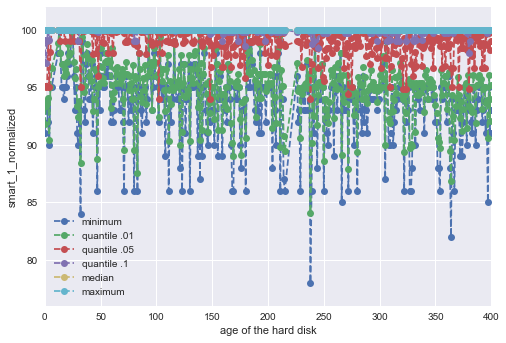

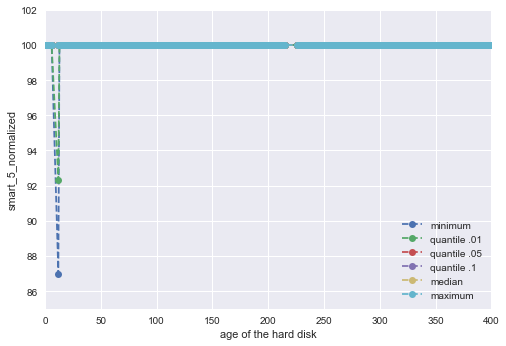

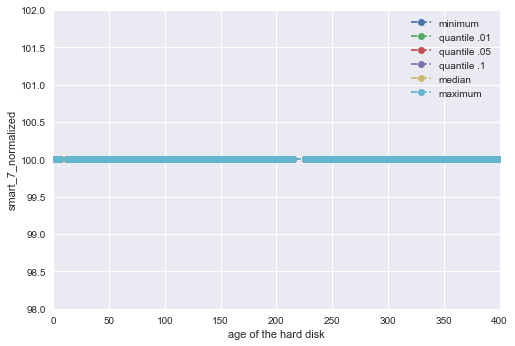

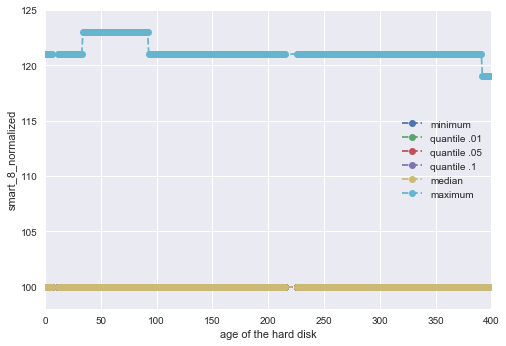

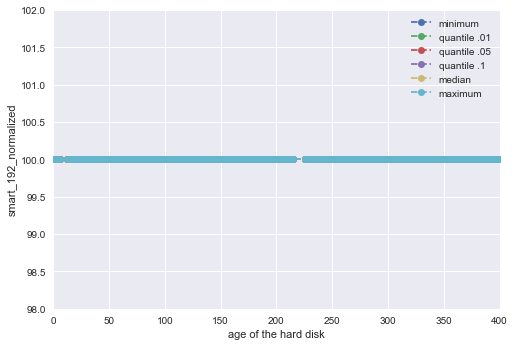

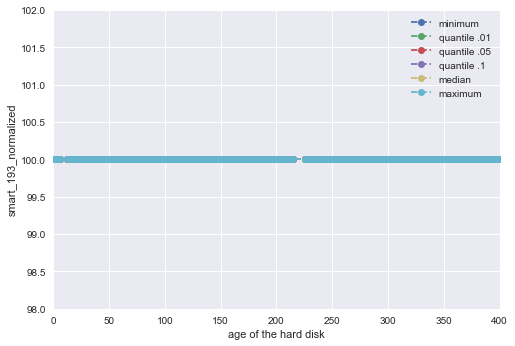

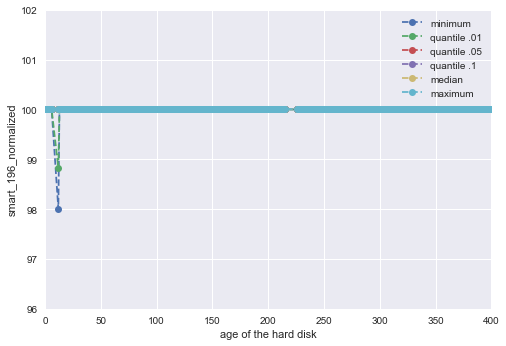

In [11]:
perc_min = df_nonpresent.groupby('D_from_first')[smart_metrics].min()
perc_010 = df_nonpresent.groupby('D_from_first')[smart_metrics].quantile(.01)
perc_050 = df_nonpresent.groupby('D_from_first')[smart_metrics].quantile(.05)
perc_100 = df_nonpresent.groupby('D_from_first')[smart_metrics].quantile(.1)
perc_500 = df_nonpresent.groupby('D_from_first')[smart_metrics].quantile(.5)
perc_max = df_nonpresent.groupby('D_from_first')[smart_metrics].max()

# We now apply CompareHistograms to every SMART metric and plot the multi-bar histograms

for smart_metric in smart_metrics :

    plt.plot(perc_min[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_010[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_050[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_100[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_500[smart_metric], marker = 'o', linestyle = '--')
    plt.plot(perc_max[smart_metric], marker = 'o', linestyle = '--')

    plt.axis( [0, 400, min(perc_min[smart_metric]) - 2, max(perc_max[smart_metric]) + 2] )
    plt.xlabel('age of the hard disk')
    plt.ylabel(smart_metric)
    plt.legend(['minimum',
                'quantile .01',
                'quantile .05',
                'quantile .1',
                'median',
                'maximum'])
    
    plt.show()

# EDA 4 : Reverse-engineering of the preventive replacement policy

Observe that in the above plots some values are missing around value 220 of 'D_from_first'. A closer look shows that all the data for HDDs having specific ages are missing. 

In the plots below, we display the missing data and we observe the following structure:

- The HDDs are off from day 7 till day 11
- The HDDs are off from day 216 till day 225
- On day 517 the HDDs are switched off. None of the HDDs not present on day 1-1-2015 is switched on after that, but some of the other HDDs reach higher ages. 

My guess is that a preventive inspection is scheduled for the HDDs after running for 6, 215, and 517 days. However, this cannot be established with certainty.

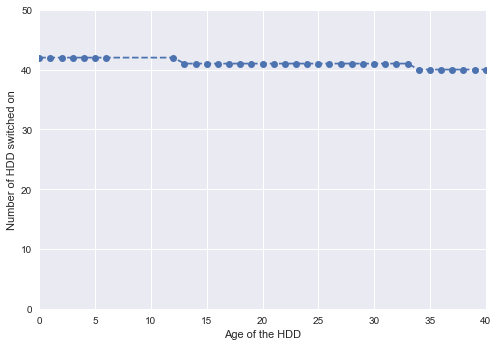

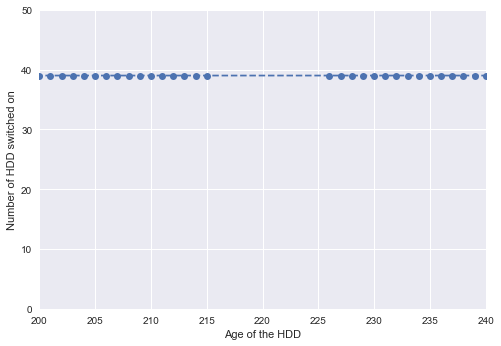

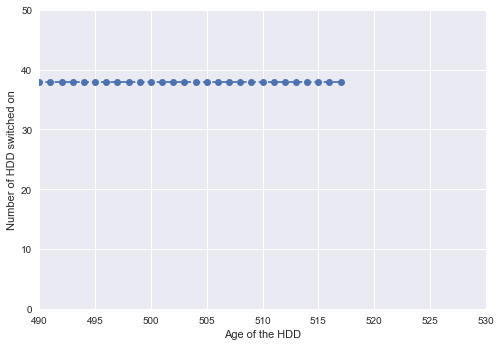

In [12]:
aux = df_nonpresent.groupby('D_from_first')['present'].count()

plt.plot(aux, marker = 'o', linestyle = '--')
plt.axis( [0, 40, 0, 50] )
plt.xlabel('Age of the HDD')
plt.ylabel('Number of HDD switched on')
    
plt.show()

plt.plot(aux, marker = 'o', linestyle = '--')
plt.axis( [200, 240, 0, 50] )
plt.xlabel('Age of the HDD')
plt.ylabel('Number of HDD switched on')
    
plt.show()

plt.plot(aux, marker = 'o', linestyle = '--')
plt.axis( [490, 530, 0, 50] )
plt.xlabel('Age of the HDD')
plt.ylabel('Number of HDD switched on')
    
plt.show()


# Inferential statistics:

Motivated by the evidences in EDA 2, we would like to understand whether the differences in the quantiles are statistically significant and what fraction of the HDDs displays an unusual behavior the day of the failure, one day before, one week ahead, and two weeks ahead.

In order to do that we distinguish the various dataframes and look at the quantiles of the SMART metrics values, in particular let $q_{a,n,s}$ be the $n$-th quantile of the SMART metric $s$ for the dataframe $a \in \{h,0,1,7,14\}$, where $h$ stands for 'healthy'. We perform the following test:

$$ \mathcal{H}_0 : q_{a,n,s} \geq q_{h,n,s}, \qquad \text{for } a=0,1,7,14.  $$

We perform the test for every SMART metric and percentiles 1, 2, 5, 10, 15, 20, 25, 50.



We obtain the following results:

- In the day of failure we can reject the hypothesis for SMART 1 up to the 25th percentile, for SMART 5 and 196 up to the 10th. Predicting such a large amount of failures would definitely be a great success.

- In the day before failure we can reject the hypothesis for SMART 1 up to the 25th percentile, for SMART 5 up to the 10th, and for SMART 196 up to the 2nd. We have almost the same results for SMART 1 and 5 with respect to the day of failure, on the other hand, it seems that SMART 196 drastically worsen exactly on the day of failure.

- One week ahead of failure we can reject the hypothesis for SMART 1 up to the 20th percentile, for SMART 5 up to the 10th, and for SMART 196 up to the 2nd. We do not lose much with respect to only one day ahead of failure.

- Two weeks ahead of a failure we obtain exactly the same results as only one week ahead.

In [13]:
def bs_unpaired_statistics_quantiles (series1, series2, q = 50, size = 1) :
    ''' Return quantiles from different days to failures '''
    series = series1.append(series2)
    stat = np.empty(size)
    for i in range(size):
        temp_perm = np.random.choice(series, len(series))
        stat[i] = np.percentile(temp_perm[:len(series1)],q) - np.percentile(temp_perm[len(series1):],q)
    return stat

quantiles = [1, 2, 5, 10, 15, 20, 25, 50]

def print_pvalue_quantiles (df_base, df_test):
    '''Compute the p-values for the test above '''
    pi_value = {}
    diff_observed = {}
    for smart_metric in smart_metrics :
        name_metric = re.sub('_normalized', '', smart_metric)
        diff_observed[name_metric] = []
        pi_value[name_metric] = []
        for q in quantiles :
            diff_obs = np.percentile(df_base[smart_metric],q) - np.percentile(df_test[smart_metric], q )
            bs_diff = bs_unpaired_statistics_quantiles (df_base[smart_metric], df_test[smart_metric], q, size = 1000 )
            pi_value[name_metric] = pi_value[name_metric] + [np.sum(bs_diff >= diff_obs)/len(bs_diff)]         
            diff_observed[name_metric] = diff_observed[name_metric] + [diff_obs]        
    return pi_value, diff_observed


In [15]:
list_K = [0, 1, 7, 14]
dict_diff = {}
pi_value = {}

for K in list_K:
    df_failure_K = df_failing[df_failing['D_to_last'] == -K]
    pi_value[K], dict_diff[K] = print_pvalue_quantiles (df_healthy, df_failure_K)
    

In the plot below, we display the comparison between the healthy HDDs and the data of HDDs at different stages of closeness to failure. 

In each plot we display the observed difference in the quantile (y-axis) as the quantiles change (x-axis). In each plot the different colors represent the different SMART metrics. The size of the marker is given by 
$200 (1 - \text{PV})$, i.e., larger marker indicates lower p-values.

- SMART metrics 7 and 8 never exhibits a significant p-value.
- SMART metrics 192 and 193 exhibits often a significant p-value but the difference observed is at most 1, i.e., these metrics are mostly constant even as we get close to failure. The observed difference of 1 is already quite difficult to obtain via bootsrapping methods but will unlikely be significant in detecting failures.
- SMART 1 exhibits significant p-value and large difference even for large quantiles. Note that the performance of the metric seems to progressively decrease in the last two weeks.
- SMART 5 and 196 exhibits significant p-value and large difference up to moderate quantiles. Note that the performance of these metrics do not seem to progressively decrease in the last two weeks (they remain quite constant).

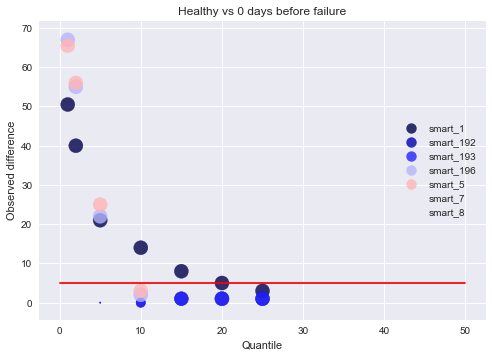

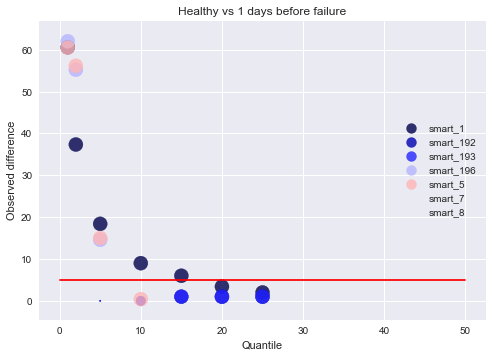

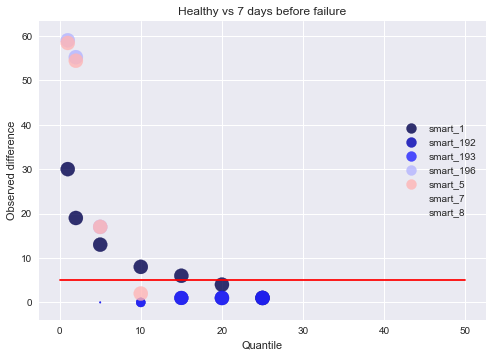

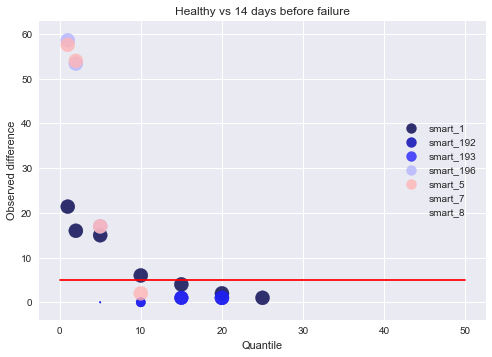

In [17]:
import matplotlib as mpl

for K in list_K :
    
    df_p = pd.DataFrame.from_dict(pi_value[K])
    name_cols = [x + '_p' for x in df_p.columns]
    df_p.columns = name_cols
    df_q = pd.DataFrame.from_dict(dict_diff[K])

    df_pq = pd.DataFrame()
    df_pq[df_q.columns] = df_q
    df_pq[df_p.columns] = df_p
    df_pq['quantiles'] = quantiles
    
    
    ax = df_pq.plot(kind="scatter", x='quantiles',y='quantiles', s = 0)
    cmap = mpl.cm.seismic
    
    for ind, sm in enumerate(df_q.columns) :
        sm_p = sm + '_p'
        df_pq.plot(kind = 'scatter', x='quantiles', y = sm, s = 200*(1 - df_pq[sm_p]), 
                   alpha = 0.8, c = cmap(ind / float(len(df_q.columns))), ax = ax, label = sm)
    
    plt.plot(np.array([0,50]), np.array([5,5]), c = 'r')
    plt.xlabel('Quantile')
    plt.ylabel('Observed difference')
    plt.title('Healthy vs %s days before failure' %K)
    plt.legend(loc='best')
    plt.show()